# <center>Logistic Regression: A Sentiment Analysis Case Study</center>


### Introduction
***


* IMDB movie reviews dataset <br>
* http://ai.stanford.edu/~amaas/data/sentiment <br>
* Contains 25000 positive and 25000 negative reviews <br>
* Contains at most reviews per movie <br>
* At least 7 stars out of 10  →  positive (label = 1) <br>
* At most 4 stars out of 10  →  negative (label = 0) <br>
* 50/50 train/test split <br>
* Evaluation accuracy <br>

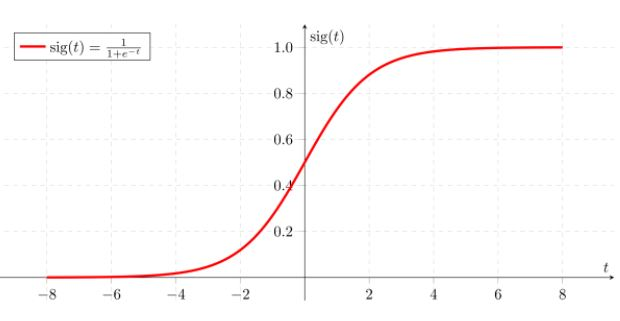

### Features: bag of 1-grams with TF-IDF values:

* Extremely sparse feature matrix - close to 97% are zeros

### Model: Logistic regression

* 𝑝(𝑦=1|𝑥)=𝜎(𝑤𝑇𝑥) 
* Linear classification model
* Can handle sparse data
* Fast to train
* Weights can be interpreted


### Task 1: Loading the Dataset
***

In [1]:
import pandas as pd

df = pd.read_csv('movie_data.csv')
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


# <center> Bag of words / Bag of N-grams model </center>

### Task 2: Transforming documents into feature vectors
***


Below, we will call the fit_transform method on CountVectorizer. This will construct the vocabulary of the bag-of-words model and transform the following three sentences into sparse feature vectors:

1. The sun is shining
2. The weather is sweet
3. The sun is shining, the weather is sweet, and one and one is two


In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [3]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [4]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


### Task 3: Word relevancy using term frequency-inverse document frequency
***


In [5]:
np.set_printoptions(precision=2)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


### Task 4: Calculate tf-idf of the term
*****


In [7]:
tf_is = 3
n_docs = 3
idf_is = np.log((n_docs+1) / (3+1))
tfidf_is = tf_is * (idf_is + 1)
print('tf-idf of term "is" = %.2f' % tfidf_is)

tf-idf of term "is" = 3.00


In [8]:
tfidf = TfidfTransformer(use_idf=True, norm=None, smooth_idf=True)
raw_tfidf = tfidf.fit_transform(count.fit_transform(docs)).toarray()[-1]
raw_tfidf

array([3.39, 3.  , 3.39, 1.29, 1.29, 1.29, 2.  , 1.69, 1.29])

In [9]:
l2_tfidf = raw_tfidf / np.sqrt(np.sum(raw_tfidf**2))
l2_tfidf

array([0.5 , 0.45, 0.5 , 0.19, 0.19, 0.19, 0.3 , 0.25, 0.19])

### Task 5:Data Preparation
***


In [10]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

In [11]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [12]:
preprocessor(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [13]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [14]:
df['review'] = df['review'].apply(preprocessor)

### Task 6: Tokenization of documents
***


In [15]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [16]:
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [17]:
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [18]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:]
if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### Task 7: Document classification via a logistic regression model
***


In [20]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [21]:
print("Review: ", X_train[1:2], "\n")
print("Sentiment: ", y_train[1])

Review:  ['ok so i really like kris kristofferson and his usual easy going delivery of lines in his movies age has helped him with his soft spoken low energy style and he will steal a scene effortlessly but disappearance is his misstep holy moly this was a bad movie i must give kudos to the cinematography and and the actors including kris for trying their darndest to make sense from this goofy confusing story none of it made sense and kris probably didn t understand it either and he was just going through the motions hoping someone would come up to him and tell him what it was all about i don t care that everyone on this movie was doing out of love for the project or some such nonsense i ve seen low budget movies that had a plot for goodness sake this had none zilcho nada zippo empty of reason a complete waste of good talent scenery and celluloid i rented this piece of garbage for a buck and i want my money back i want my 2 hours back i invested on this grade f waste of my time don t w

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)



### Task 8: Load saved model from disk
***


In [28]:
import pickle

In [30]:
filename = '/saved_model.sav'
gs_lr_tfidf = pickle.load(open(filename, 'rb'))

In [31]:
print('Best parameter set: %s' % gs_lr_tfidf.best_params_)
print('CV Accuracy:%.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7f8b709a1050>}
CV Accuracy:0.897


In [32]:
!pip install scikit-learn==0.20.2